# TP1 Proximal Denoising

* Authors: Mengda Li, Ségolène Martin

## Question 1
Show that this problem amounts to calculate the proximity operator of a
function in $\Gamma_0$.

**_Claim 1.1_**: $f \circ L \in \Gamma_0$

**Proof**:
> 1. Right composition of a convex function by an affine function is still convex. Since $f \in \Gamma_0$ and $L$ is linear (so affine), $f \circ L$ is convex.
2.  Right composition of a lower semicontinuous function by a continuous function is still lower semicontinuous. Since $f$ is lower semicontinuous and $L$ is continuous (linear and the dimension of its set of departure is finite), $f \circ L$ is lower semicontinuous.
3. $f \circ L$ is proper as a composition of proper fonctions.

As $f \circ L \in \Gamma_0$, Prox$_{f\circ L}: y \ \mapsto \ \underset{x}{\arg\min} f(Lx) + \frac{1}{2} \|x - y \|^2$ is our goal of optimization problem.

## Question 2
Check that this is also equivalent to calculate $L^{−1} Prox_f (Ly)$.

As $L$ is linear and continuous, $f \in \Gamma_0$, and $LL^* = Id$, (by slide 16) $Prox_{f \circ L} (y) = y + L^*(Prox_f(Ly) -Ly)$. Hence :

\begin{align}
Prox_{f \circ L} (y) &= y + L^*(Prox_f(Ly) -Ly) \\
    & = y + L^*(Prox_f(Ly)) - y  \tag*{$(L^*L = Id)$}\\
    & = L^{-1}(Prox_f(Ly)) \tag*{$(L^* = L^{-1})$ }
\end{align}

## Question 3
Download the florence.jpg image. Add to this image a white Gaussian noise
with zero-mean and standard deviation equal to 30.

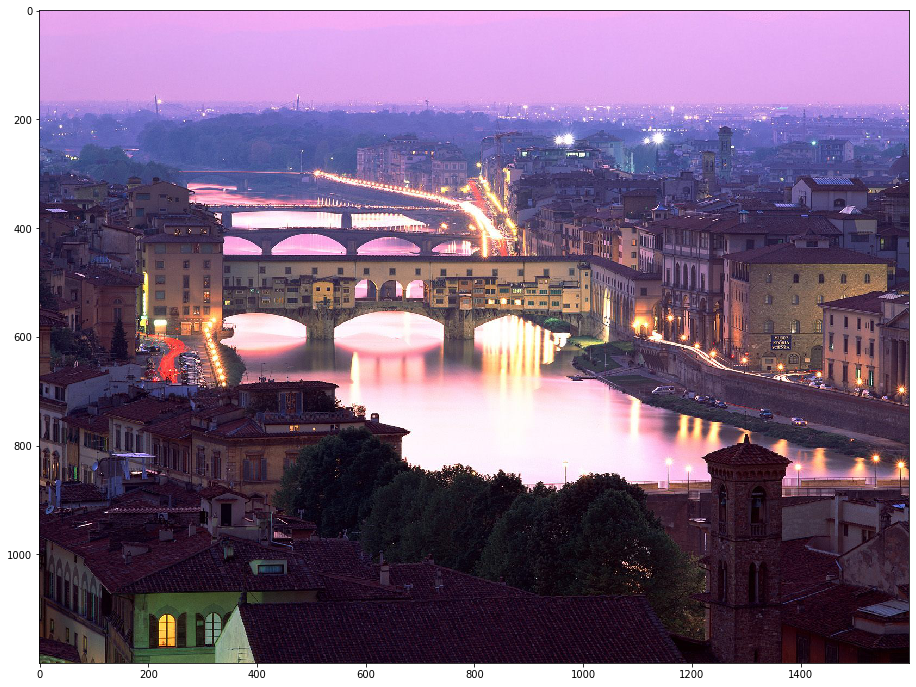

In [19]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

im = imageio.imread('./florence.jpg')
plt.figure(figsize=(16,12))
plt.imshow(im);

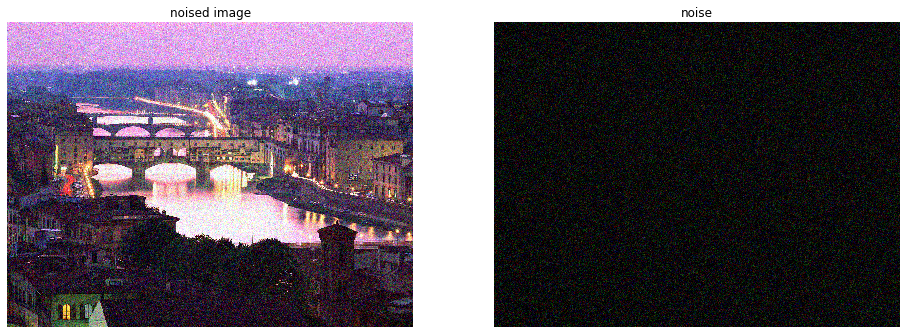

In [18]:
noise = np.random.normal(scale = 30, size = im.shape)
noised = im + noise

f = plt.figure(figsize=(16,24))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.set_title('noised image')
ax1.axis("off")
ax2.set_title('noise')
ax2.axis("off")
ax1.imshow(np.clip(noised, 0, 255).astype(np.uint8))
ax2.imshow(np.clip(noise, 0, 255).astype(np.uint8));

Note that, in this TP, we reserve $im, noised$ as global variables.

## Question 4

Compute the minimizer of (1) when L is a 2D orthonormal wavelet decomposition.

Let $N$ be the size of the image. Here $N = 1600 \times 1200 $.

**_Claim 4.1_**: For all $i\in  [\![1,N]\!] \!$ , $f_i \in \Gamma_0$.

**Proof**:
> 1. $0 \in \Gamma_0$ clearly
2. $\cdot \mapsto | \cdot |$ is convex, $x \mapsto x^q$ is convex and non-decreasing in $\mathbb{R}^+$ for all $q \ge 1$ so $\cdot \mapsto | \cdot |^q$ is still convex. In addition, $\chi > 0$ so $\phi$ is convex. $\phi$ is continuous as composition of continuous functions, and is proper as composition of proper functions.

As $f$ is separable, $f_i \in \Gamma_0$ and $f_i \geq 0$ for all $i\in  [\![1,N]\!] \!$ , we have $Prox_f = (Prox_{f_i})_{i \in [\![1,N]\!]}$. $Prox_0$ is just identity function while $Prox_\phi$ has a close form in the lecture slide. 

The folowing steps are computed on each RGB channel.
> 1. Compute $Ly$, the 2D wavelet decomposition by some specific wavelet basis (like Haar i.e. db1)
2. Compute the the proximal operator in each level of decomposition: we keep the approximation coefficients because $Prox_0 = Id$ and we compute the value of $Prox_\phi$ on the other sets of coefficients.
3. Left compose the result by $L^{-1}$ which is the wavelet recompostion of $Prox_f(Ly)$ by the same wavelet basis we used before.

We show some numerical experiments after the code. In this TP, we always use Haar wavelet for decomposition and recomposition.

In [4]:
import pywt

In [5]:
def denoising(image, q, chi, Level = None, wavelet = 'db1'):
    L = pywt.wavedec2(image, wavelet, axes=(0,1), level=Level)
    for level in range(1, len(L)):
        L[level] = list(L[level])
        for i in range(3):
            Coeff = L[level][i]
            if q == 1 :
                L[level][i] = np.sign(Coeff)*np.maximum(abs(Coeff)-chi,0)
            elif q == 4/3 :
                eps = np.sqrt(Coeff**2 +256*chi**3/729)
                L[level][i] = Coeff+ 4*chi*((eps-Coeff)**(1/3) - (eps+ Coeff)**(1/3))/(3*2**(1/3))
            elif q == 3/2 :
                L[level][i] = Coeff + 9* chi**2 * np.sign(Coeff)*(1-np.sqrt(1+ 16*np.abs(Coeff)/(9*chi**2)))/8
            elif q == 2 :
                L[level][i] = Coeff/(1+2*chi)
            elif q == 3:
                L[level][i] = np.sign(Coeff)*(np.sqrt(1+12*chi*np.abs(Coeff)) -1)/(6*chi)
            elif q == 4 :
                eps = np.sqrt(Coeff**2 + 1/(27*chi**2))
                L[level][i] = ((eps + Coeff)/(8*chi))**(1/3) - ((eps - Coeff)/(8*chi))**(1/3)
    denoised = pywt.waverec2(L, wavelet, axes=(0,1))   
    return(denoised)

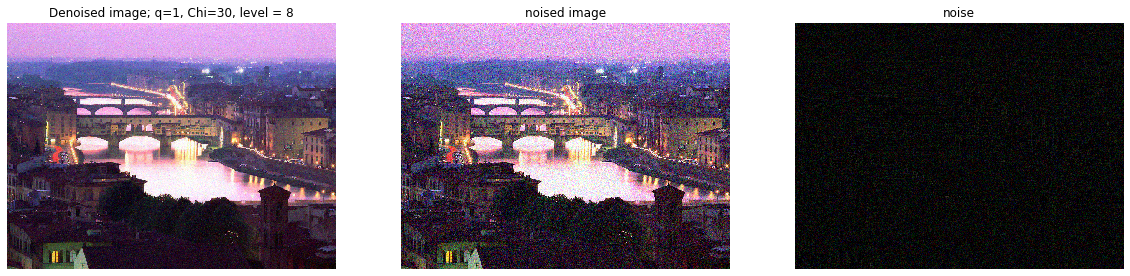

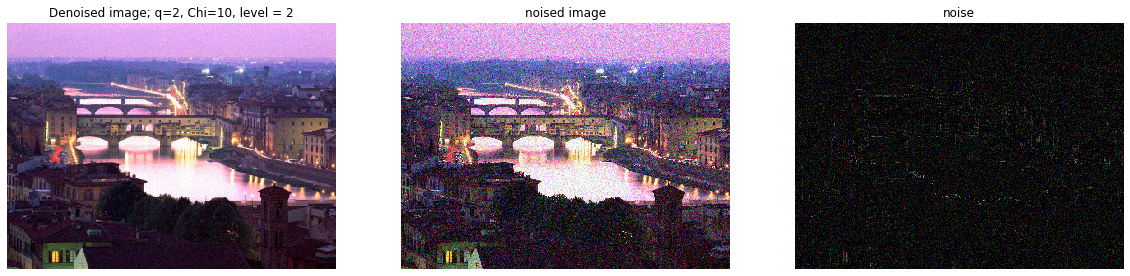

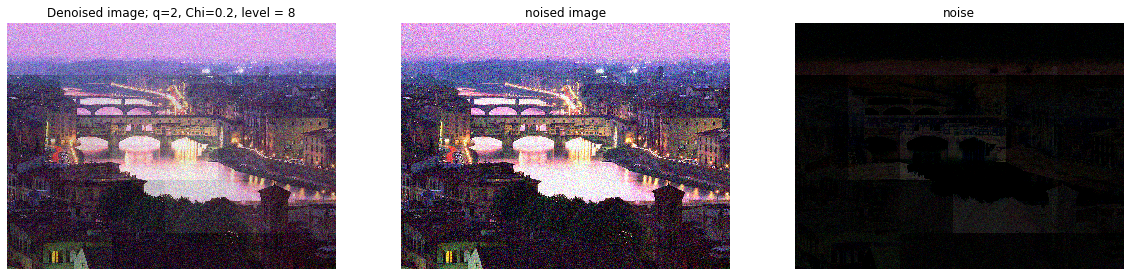

In [17]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.figure(1)
denoised = denoising(noised, 1, 30, 8)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('Denoised image; q=1, Chi=30, level = 8')
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noised image')
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noise')

plt.figure(2)
denoised = denoising(noised, 2, 10, 2)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('Denoised image; q=2, Chi=10, level = 2')
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noised image')
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noise')

plt.figure(3)
denoised = denoising(noised, 2, 0.2, 8)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('Denoised image; q=2, Chi=0.2, level = 8')
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noised image')
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noise');

### Optimisation of $\chi$ and of the number of levels.

In this part we study the choice of $\chi$ and of the number of levels by looking at $MSE = \frac{\Vert x - \widehat{x} \Vert}{\left\lVert x \right\rVert}$ where $x$ is the original image and $\widehat{x}$ is the denoised image obtained from denoising$(x, q, \chi, level)$.

NE PAS LANCER LE CODE : TRES LONG

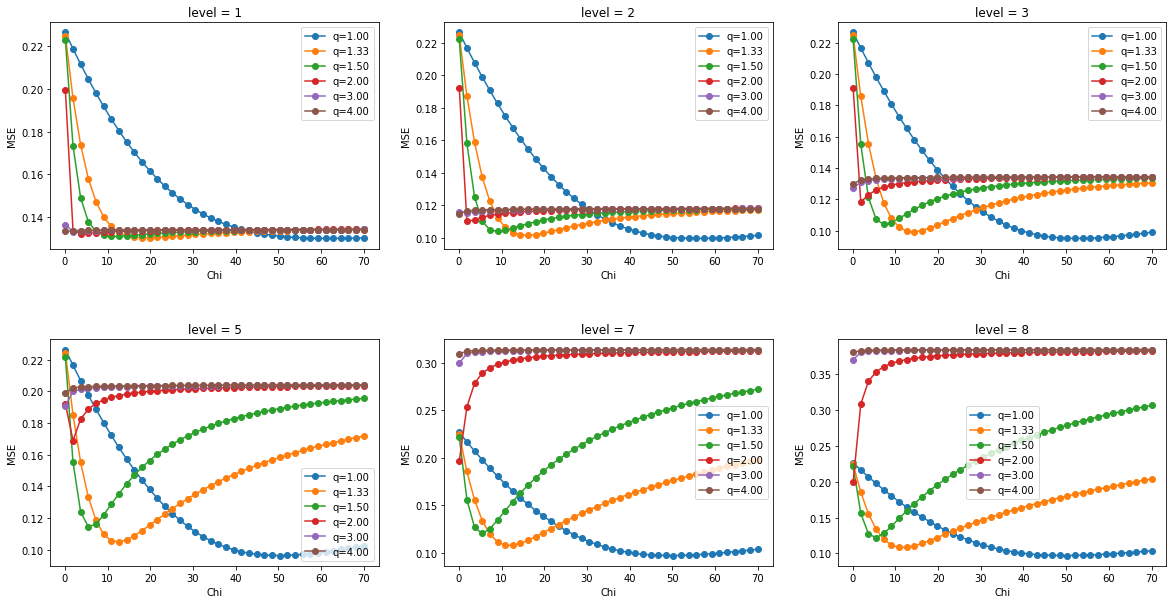

In [15]:
def MSE_chi(image, Level = None, wavelet = 'db1', noised = noised):
    list_chi = np.linspace(0.1, 70, 40 )
    IM_NORM = np.linalg.norm(image)
    for i,q in enumerate([1, 4/3, 3/2, 2, 3, 4]):
        MSE = []
        for chi in list_chi :
            denoised = denoising(noised, q, chi, level)
            MSE.append(np.linalg.norm(denoised-image)/IM_NORM)
        plt.plot(list_chi, MSE, 'o-', label='q={:1.2f}'.format(q))
        plt.legend()

# Test pour différents levels
list_level = [1,2,3,5,7,8]
plt.figure(4)
plt.subplots_adjust(hspace = 0.40)
for i,level in enumerate(list_level) :
    plt.subplot(2,3,i+1)
    MSE_chi(im, level)    
    plt.title('level = {}'.format(level))
    plt.xlabel('Chi')
    plt.ylabel('MSE')

    

According to the plot above the best denoising is achieved by $q=1$, $\chi \simeq 45$, $level=3$, which gives the following result :

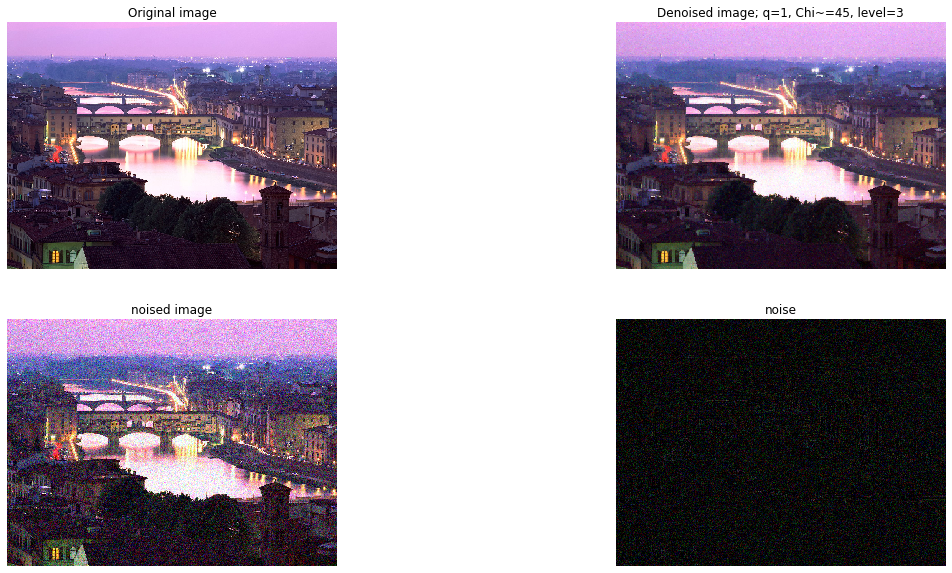

In [16]:
plt.figure(1)
denoised = denoising(noised, 1, 45, 3)
plt.subplot(2,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('Denoised image; q=1, Chi~=45, level=3')
plt.subplot(2,2,3)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noised image')
plt.subplot(2,2,4)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))
plt.axis('off')
plt.title('noise');

### Obeservation and comments 

We could conjecture that there is a kind of duality between the power of penalty function $q$ and the level of wavelet decomposition.

When the decomposition level is $\le 2$, the penalty on approximation coefficients with a power $q \ge 2$ behaves relatively well: the MSE decreases as faster w.r.t $\chi$ as $q$ is bigger. On the other hand, as soon as the decomposition level is $>2$, the limit of MSE will remain significantly higher than the ones with power smaller than 2, and what's more the limit of MSE is as higher as the level is higher.

The proximity operator with higher power $q$ induces a rapide decreasing of MSE w.r.t $\chi$ in the low decomposition level, and that is intuitive because the slope of higher power function is steeper. However, they are less stable and their limit in MSE is *premature* (so not as good as) than smaller powerful ones. As the level goes up, their MSE limit goes higher and higher suffering from their premature convergence. The proximity operator with $q=1$ converges the most slowly but enjoys the most stable limit.